In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

df_train = pd.read_csv('train_final.csv')
df_test = pd.read_csv('test_final.csv')

In [2]:
target = df_train["Y"]
id = df_test["Id"].values

df_train.drop(['Id','Y'],axis=1,inplace=True)
df_test.drop(['Id'],axis=1,inplace=True)

In [3]:
print('Binary features summary statistics')
df_train.describe().T.style.bar(subset = ['mean'], color = 'grey').bar(subset = ['std'],color = 'grey').background_gradient(cmap = 'GnBu')

Binary features summary statistics


,count,mean,std,min,25%,50%,75%,max
2,2603.000000,0.000768,0.027714,0.000000,0.000000,0.000000,0.000000,1.000000
3,2603.000000,0.463312,0.498748,0.000000,0.000000,0.000000,1.000000,1.000000
4,2603.000000,-46.734537,394.284920,-3136.000000,0.000000,0.000000,0.000000,1175.000000
5,2603.000000,0.000768,0.027714,0.000000,0.000000,0.000000,0.000000,1.000000
6,2603.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,2603.000000,0.275836,0.447020,0.000000,0.000000,0.000000,1.000000,1.000000
8,2603.000000,0.023434,0.151308,0.000000,0.000000,0.000000,0.000000,1.000000
9,2603.000000,0.000384,0.019600,0.000000,0.000000,0.000000,0.000000,1.000000
10,2603.000000,0.955436,0.206384,0.000000,1.000000,1.000000,1.000000,1.000000
11,2603.000000,0.001921,0.043794,0.000000,0.000000,0.000000,0.000000,1.000000


In [4]:
# drop_zeros = ['6','30','35', '40', '60','80', '90', '101','102', '113', '118', '129', '138', '142','163', '206', '216', '233', '239', '247','250', '253', '259', '305', '307', '315', '322', '323', '333', '350', '364', '120', '208']

# df_train =  df_train.drop(drop_zeros,axis=1)        
# df_test = df_test.drop(drop_zeros,axis=1)
#log transform skewed numeric features:
# from scipy.stats import skew

# skewed_feats = df_train.apply(lambda x: skew(x.dropna())) #compute skewness
# skewed_feats = skewed_feats[skewed_feats > 0.75]
# skewed_feats = skewed_feats.index

# df_train[skewed_feats] = np.log1p(df_train[skewed_feats])
# # skewed_feats
# df_train[['63','132', '382','198', '146']] = np.log1p(df_train[['63','132', '382','198', '146']])
# df_test[['63','132', '382','198', '146']] = np.log1p(df_test[['63','132', '382','198', '146']])

In [5]:
from sklearn import preprocessing

#columns = ['4','63','132', '146', '180','382', '119', '198', '379']
columns = ['4','180',  '379']

scale_train = preprocessing.RobustScaler().fit(df_train[columns])
df_train[columns] = scale_train.transform(df_train[columns])

scale_test = preprocessing.RobustScaler().fit(df_test[columns])
df_test[columns] = scale_test.transform(df_test[columns])

minmax_scale_train = preprocessing.MinMaxScaler().fit(df_train[columns])
df_train[columns] = minmax_scale_train.transform(df_train[columns])

minmax_scale_test = preprocessing.MinMaxScaler().fit(df_test[columns])
df_test[columns] = minmax_scale_test.transform(df_test[columns])

In [6]:
x_train, x_test, y_train, y_test = train_test_split(df_train, target, test_size=0.33, random_state=1)

In [18]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

para = { 'learning_rate': 0.02, 'iterations': 1000, 'depth': 9,  "verbose":0,  "class_weights":[0.55,0.45]}

catboost = CatBoostClassifier(**para)

catboost.fit(df_train, target)

y_proba = catboost.predict_proba(x_test)
print(roc_auc_score(y_test, y_proba[:,1]))



y_pred = catboost.predict(x_test)

score = (accuracy_score(y_test, y_pred)) * 100
print("Accuracy score is %.2f%%" % score)

1.0
Accuracy score is 100.00%


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


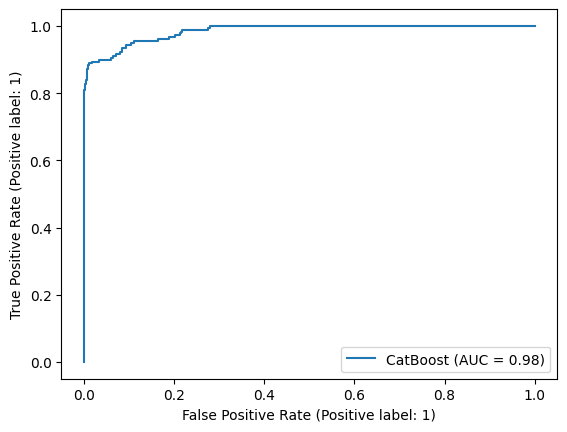

In [8]:
# 0.996910943148209
# Accuracy score is 97.44%

plot_roc_curve(catboost, x_test, y_test, name = 'CatBoost')

In [15]:
sub_proba = catboost.predict_proba(df_test)
pred_col=np.c_[id,sub_proba[:,1]]

submission = pd.DataFrame(pred_col, columns = ['Id','Y'])
submission["Id"] = submission["Id"].astype("Int32")
submission

,Id,Y
0,2604,0.007621
1,2605,0.035642
2,2606,0.022211
3,2607,0.003937
4,2608,0.670342
...,...,...
3599,6203,0.083520
3600,6204,0.015872
3601,6205,0.004026
3602,6206,0.023549


In [16]:
submission.to_csv('lastdaypart1submission.csv', index=False)